In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vincenty import vincenty #
import pickle
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
geolocator = Nominatim(user_agent="TEST")
import warnings
import random
import folium
import copy
from scipy.stats import gaussian_kde
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')

# On load les données

In [2]:
# cours - load train and test data
path = '/Users/Lingli/Documents/Lingli/Telecom-Paris/InternetObjets/TP_geoloc/'
mess_train = pd.read_csv(path+'mess_train_list.csv') # données TRAIN
pos_train = pd.read_csv(path+'pos_train_list.csv') # POSITION TRAIN
mess_test = pd.read_csv(path+'mess_test_list.csv') # donnée TEST, modèle à appliquer
print('   dimension mess_train:\t', mess_train.shape, '\tdimension mess_test:\t', mess_test.shape, '\n', '  dimension pos_train:\t\t', pos_train.shape,'\n')

   dimension mess_train:	 (39250, 8) 	dimension mess_test:	 (29286, 8) 
   dimension pos_train:		 (39250, 2) 



#### Nous joingnons les df de X et Y afin de pouvoir dropper sans créer de décalage de ligne entre ces 2 df

In [4]:
data_train_all = mess_train.join(pos_train)
print('Il y a au total:', data_train_all.shape[0], 'messid (Train + Test)')

Il y a au total: 39250 messid (Train + Test)


<br>L'objectif de ce projet est d'entrainer un modèle avec les données ci-dessus, afin de localiser des devises.
<br>Nous disposons pour chaque message, l'id de chaque base station qui l'a reçu, sa latitude, sa longitude. 
<br>La qualité de la location va dépendre des informations collectées par les bases stations. 
<br>Les autres informations (nseq,time_ux) ne semblent pas pertinentes pour l'objectif poursuivi. 

In [6]:
list_1 = mess_train.bsid.unique().tolist()
list_1.sort(reverse=False)
list_2 = mess_test.bsid.unique().tolist()
list_2.sort(reverse=False)
print(' Nombre de bases station dans les données Train', len(list_1), '\n Nombre de base stations dans les données Test', len(list_2))


 Nombre de bases station dans les données Train 251 
 Nombre de base stations dans les données Test 168


In [7]:
list_commmune = []

for i in range(len(list_2)):
    if list_2[i] not in list_1:
        pass
    else :
        list_commmune.append(list_2[i])
print(' Sur les', len(list_2),'bases stations du Test nous retrouvons', len(list_commmune), 'dans la base Train')
print(' Il y a donc 8 bases station de la base de données Test non présentes dans la base Train')

 Sur les 168 bases stations du Test nous retrouvons 160 dans la base Train
 Il y a donc 8 bases station de la base de données Test non présentes dans la base Train


In [8]:
data_train_all = mess_train.join(pos_train)
print('Il y a au total:', data_train_all.shape[0], 'messid (Train + Test)')

Il y a au total: 39250 messid (Train + Test)


#### Nous vérifions s'il y a des messid dupliqués entre le jeu de données TRAIN et TEST

In [9]:
messid_all = pd.DataFrame(mess_train.messid.unique()).append(pd.DataFrame(mess_test.messid.unique()))
duplicate = messid_all.duplicated().astype(int)
print('Il y a', duplicate.sum(), 'donnée(s) dupliquées entre le TRAIN et le TEST')

Il y a 0 donnée(s) dupliquées entre le TRAIN et le TEST


<div class="alert alert-block alert-info"; div align="center">
<span style="font-size:2em";> I - FONCTIONS </span></b></div>

Vous trouverez ci-dessous la liste de toutes les fonctions que nous avons crées. 
Certaines nous ont simplement permis de mieux comprendre les données. 
Elles n'ont pas été toutes utilisées pour le pre-processing. 

### Calcule la différence de latitude entre celle de la base station et la vraie latitude

In [13]:
def cal_diff_lat(data_train_all):
    '''
    Choix base TRAIN only ! 
    X est la matrice qui compile toutes les données sur le train (mess_train et pos_train)!!
    on ajoute une colonne avec la différence de lat entre la bs et la vraie latitude
    '''
    data_train_all['diff_lat'] = data_train_all['bs_lat'] - data_train_all['lat']
    return data_train_all

def drop_cal_diff_lat(data_train_all):
    '''
    On drop la colonne 'diff_lat' si on ne la veut plus dans la matrice.
    '''
    if 'diff_lat' in data_train_all:
        data_train_all = data_train_all.drop(columns=['diff_lat'])
    else:
        pass
    return data_train_all

### Calcule la différence de longitude entre celle de la base station et la vraie longitude

In [14]:
def cal_diff_lng(data_train_all):
    '''
    Choix base TRAIN only ! 
    X est la matrice qui compile toutes les données sur le train (mess_train et pos_train)
    on ajoute une colonne avec la différence de longitude entre le bs et la vraie longitude
    '''
    data_train_all['diff_lng'] = data_train_all['bs_lng'] - data_train_all['lng']
    return data_train_all

def drop_diff_lng(data_train_all):
    '''
    On drop la colonne 'diff_lng' si on ne la veut plus dans la matrice.
    '''
    if 'diff_lng' in data_train_all:
        data_train_all = data_train_all.drop(columns=['diff_lng'])
    else:
        pass
    return data_train_all

### Calcule la distance en km entre la lat/lng de la bsid et la vraie lat/lng

In [15]:
def cal_distance(X):
    '''
    Choix base TRAIN only car nous avons besoin des vraies lat et lng! 
    '''
    if 'distance' in X: 
        X = X.drop(columns=['distance'])
        X['distance']= X.apply(lambda x: geodesic((x['lat'], x['lng']), (x['bs_lat'], x['bs_lng'])).km, axis = 1)
    else:
        X['distance']= X.apply(lambda x: geodesic((x['lat'], x['lng']), (x['bs_lat'], x['bs_lng'])).km, axis = 1)
    return X

def drop_distance(X):
    '''
    On drop la colonne 'distance' si on ne la veut plus dans la matrice.
    '''
    if 'distance' in X:
        X = X.drop(columns=['distance'])
    else:
        pass
    return X

### Drop la ligne si trop de différence avec les vraies lat et lng

In [16]:
def drop_row_if_diff_max_upper_bound(data_train, diff_max=2):
    '''
    Choix base TRAIN only !
    diff_max = mettre la différence max 
    
    '''
    data_train['max_diff_lat_lng'] =  np.maximum(abs(data_train['bs_lat'] - data_train['lat']), 
                                                    abs(data_train['bs_lng'] - data_train['lng']))
    
    print('Il y avait', data_train.shape[0],'lignes au début')
    data_train_1 = data_train.loc[data_train_all['max_diff_lat_lng']< diff_max]
    print('Il y a', data_train.shape[0],'lignes après la sélection. Nous avons retiré', data_train.shape[0] - data_train.shape[0],'lignes')
    
    print('\nIl y a',len(data_train.loc[data_train['max_diff_lat_lng']> diff_max]['messid'].unique()), 
      'messid pour lesquels, la distance avec les vraies coordonnées lat et lng est supérieure à', diff_max)
    print('Il y a', len(data_train.loc[data_train['max_diff_lat_lng']> diff_max]['bsid'].unique()), 
      'bsid pour lesquels, la distance avec les vraies coordonnées lat et lng est supérieure à', diff_max)
    
    return data_train_1

### Calcule le nombre de bsid par message

In [17]:
def cal_nb_bsid_per_messid(X):
    '''
    Choix base TRAIN et TEST
    calcul le nombre de bases station pour chaque message id
    '''
    X['nb_bsid_per_messid'] = X.groupby('messid')['bsid'].transform('count')
    return X

def drop_nb_bsid_per_messid(X):
    '''
    On drop la colonne 'nb_bsid_per_messid' si on ne la veut plus dans la matrice.
    '''
    if 'nb_bsid_per_messid' in X:
        X = X.drop(columns=['nb_bsid_per_messid'])
    else:
        pass
    return X

### Calcule le nombre de messid reçu par la base station id

In [18]:
def cal_nb_messid_received_per_bsid(X):
    '''
    Choix base TRAIN et TEST
    On regarde pour chaque bsid, combien de messid elle a reçu, si elle est beaucoup utilisée.
    '''
    X['nb_messid_received_per_bs'] = X.groupby('bsid')['messid'].transform('count')
    return X

def drop_nb_messid_received_per_bsid(X):
    '''
    On drop la colonne 'nb_messid_received_per_bs' si on ne la veut plus dans la matrice.
    '''
    if 'nb_messid_received_per_bs' in X:
        X = X.drop(columns=['nb_messid_received_per_bs'])
    else:
        pass
    return X

### Création d'un dataframe avec uniquement les messid filmtré par nombre des bsid

In [19]:
def df_messid_big_nb_bsid(train, test, nb_bsid=2):
    '''
    On selection toutes les messid qui ont un nombre de base station STRICTEMENT SUPERIEUR à nb_bsid
    Applique en meme temps le même filtre sur le mess_test pour ne pas oublier
    '''
    train = cal_nb_bsid_per_messid(train)
    data_train_all_big_nb_bsid = train.loc[train['nb_bsid_per_messid'] > nb_bsid]
    
    test = cal_nb_bsid_per_messid(test) # fait automatique sur mess_test pour ne pas l'oublier
    mess_test_big_nb_bsid = test.loc[test['nb_bsid_per_messid'] > nb_bsid]
       
    return data_train_all_big_nb_bsid, mess_test_big_nb_bsid

### Liste des messid qui ont plus de XX bsid

In [21]:
def list_messid_multiple_bsid(X, upper_bound=2):
    '''
    Choix base TRAIN et TEST
    upper_bound = mettre le nombre à partir duquel on veut avoir la liste
    '''
    df_mess_count = pd.DataFrame(X.groupby('messid').agg({'bsid': ['unique', 'count']}).to_records())
    df_mess_count.columns = ['messid', 'index_mess','count']
    df_mess_unique = df_mess_count.drop(df_mess_count[df_mess_count['count'] < upper_bound].index)
    
    return df_mess_unique 

### Liste des bases stations qui partagent la même pair de lat/lng avec une autre base station id

In [22]:
def list_bs_with_duplicated_lat_lng(X):
    '''
    Choix base TRAIN et TEST
    liste des bases stations qui ont les mêmes latitudes et longitude qu'une autre base station
    '''
    bs = X[['bsid', 'bs_lat', 'bs_lng']]
    bs_unique = bs.drop_duplicates()
    lat_lng_unique = bs_unique[['bs_lat', 'bs_lng']].drop_duplicates()
    duplicated_lat_lng = bs_unique[bs_unique.duplicated(['bs_lat', 'bs_lng'], keep=False)]
    
    return duplicated_lat_lng

### Remplace les bd lat= 64.300000 et lng = -68.500000 par la mediane des autres bases stations du même messid

In [24]:
def replace_bs_lat_lng_wrong_by_median(X): 
    '''
    Choix base TRAIN et TEST
    On remplace les lat= 64.300000 et lng = -68.500000 par la médiane des autres bases stations du messid
    ATTENTION, ne pas oublier de le faire sur le Xtest
    '''
    
    X = cal_nb_bsid_per_messid(X)
    
    # On traite les lat égaux à 64.300000
    X['bs_lat'] =  X['bs_lat'].replace(64.300000, np.nan)
    X['bs_lat_median'] = X.groupby('messid')['bs_lat'].transform('median') 
    X.bs_lat[X.bs_lat.isna()] = X.bs_lat_median

    # On traite les lng égaux à -68.500000
    X['bs_lng'] =  X['bs_lng'].replace(-68.500000, np.nan)
    X['bs_lng_median'] = X.groupby('messid')['bs_lng'].transform('median') 
    X.bs_lng[X.bs_lng.isna()] = X.bs_lng_median
    
    X.drop(['bs_lat_median', 'bs_lng_median'] , axis=1 , inplace=False)
    
    # Pour les messid qui ont une seule bs, on remet cette valeur
    X['bs_lat'] =  X['bs_lat'].replace(np.nan, 64.300000)
    X['bs_lng'] =  X['bs_lng'].replace(np.nan, -68.500000)
    return X


### Calcule la lat et lng mean des messid qui ont une seule bsid

In [25]:
def cal_mean_lat_lng_messid_all_wrong_bsid(X):
    '''
    Choix Train seulement.
    Nous calculons la médiane lat et lng de tous les messig qui ont 1, 2 ou 3 bsid dont 
    les lat et lng sont différents de 64.300000 et -68.500000. 
    '''
    X = cal_nb_bsid_per_messid(X) 
    
    mean_lat_1 = X.loc[(X.nb_bsid_per_messid == 1) & (X.bs_lat != 64.300000)]['bs_lat'].mean()
    mean_lng_1 = X.loc[(X.nb_bsid_per_messid == 1) & (X.bs_lng != -68.500000)]['bs_lng'].mean()
    
    mean_lat_2 = X.loc[(X.nb_bsid_per_messid == 2) & (X.bs_lat != 64.300000)]['bs_lat'].mean()
    mean_lng_2 = X.loc[(X.nb_bsid_per_messid == 2) & (X.bs_lng != -68.500000)]['bs_lng'].mean()
    
    mean_lat_3 = X.loc[(X.nb_bsid_per_messid == 3) & (X.bs_lat != 64.300000)]['bs_lat'].median()
    mean_lng_3 = X.loc[(X.nb_bsid_per_messid == 3) & (X.bs_lng != -68.500000)]['bs_lng'].median()
    
    return mean_lat_1, mean_lng_1, mean_lat_2, mean_lng_2, mean_lat_3, mean_lng_3

### On remplace les lat et lng par le mean des lat et lng des vraies positions pour les messid qui ont uniquement une seule bsid

In [26]:
def replace_by_mean_all_wrong_bsid(X):
    '''
    Pour tous les messid qui ont uniquement une seule bsid et qui se trouvent au Canada,
    nous remplacons leur bs_lat et bs_lng par la médiane des autres messid qui ont 
    le même nombre de bases station.
    '''
    mean_lat_1, mean_lng_1, mean_lat_2, mean_lng_2, mean_lat_3, mean_lng_3 = cal_mean_lat_lng_messid_all_wrong_bsid(X)
          
    X.loc[(X['nb_bsid_per_messid'] == 1 ) &  (X['bs_lat'] == 64.300000), 'bs_lat'] = mean_lat_1
    X.loc[(X['nb_bsid_per_messid'] == 1 ) &  (X['bs_lng'] == -68.500000), 'bs_lng'] = mean_lng_1
    
    X.loc[(X['nb_bsid_per_messid'] == 2 ) &  (X['bs_lat'] == 64.300000), 'bs_lat'] = mean_lat_2
    X.loc[(X['nb_bsid_per_messid'] == 2 ) &  (X['bs_lng'] == -68.500000), 'bs_lng'] = mean_lng_2
    
    X.loc[(X['nb_bsid_per_messid'] == 3 ) &  (X['bs_lat'] == 64.300000), 'bs_lat'] = mean_lat_3
    X.loc[(X['nb_bsid_per_messid'] == 3 ) &  (X['bs_lng'] == -68.500000), 'bs_lng'] = mean_lng_3
    
    return X

In [27]:
def positive_x(X):
    '''
    Permet de soustraire la valeur RSSI du minimum de l'ensemble des RSSI. 
    '''
    
    X_2 = copy.deepcopy(X)
    X_2['rssi'] = X_2['rssi'].apply(lambda x: x - X_2['rssi'].min())
    return  X_2

In [28]:
def powed(X):
    '''
    Pénalise les valeurs les plus grands afin de réduire l'écart entre les valeurs extrêmes.
    '''
    minimum = X['rssi'].min()
    min_neg = minimum*(-1)
    X_2 = positive_x(X)
    X_2['rssi'] = X_2['rssi'].apply(lambda x:pow((x/min_neg),np.e))
    return X_2

<div class="alert alert-block alert-info"; div align="center">
<span style="font-size:2em";> II - Analyse </span></b></div>

### Répartition des bsid par messid

In [29]:
data = data_train_all.groupby("messid").count()["bsid"]
messid_1bs = data[data==1].count()
messid_equalOrless_3_bs = data[data<=3].count()
messid_equalOrless_10_bs = data[data<=10].count()
messid_more_30 = data[data>30].count()
messid_more_50 = data[data>50].count()

print("\tmessid reçus par 1bs: %2.2f" %(messid_1bs / data.count() * 100), "%")
print("\tmessid reçus par jusqu'à 3 bs: %2.2f" %(messid_equalOrless_3_bs / data.count() * 100), "%")
print("\tmessid reçus par jusqu'à 10 bs: %2.2f" %(messid_equalOrless_10_bs / data.count() * 100), "%")
print("\tmessid reçus par plus de 30 bs: %2.2f" %(messid_more_30 / data.count() * 100), "%")
print("\tmessid reçus par plus de 50 bs: %2.2f" %(messid_more_50 / data.count() * 100), "%")

	messid reçus par 1bs: 21.90 %
	messid reçus par jusqu'à 3 bs: 52.03 %
	messid reçus par jusqu'à 10 bs: 83.04 %
	messid reçus par plus de 30 bs: 2.50 %
	messid reçus par plus de 50 bs: 1.10 %


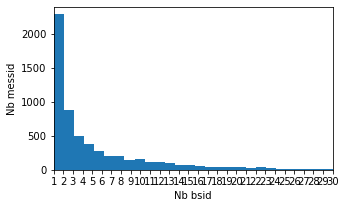

In [30]:
plt.figure(figsize=(5,3))
plt.hist(data, bins= 100)
plt.xlabel("Nb bsid")
plt.ylabel("Nb messid")
plt.xlim([1, 30])
plt.xticks(np.arange(1, 30+1, 1.0))
plt.show()

Nous constatons que:
<li>plus de 20% des messid n'ont qu'une seule bsid. 
<li>Plus de la moitié des messid ont moins de 3 bsid. 
<br>Ainsi, la qualité de ces bsid va être essentielle. Nous allons donc regarder la qualité du signal reçue par les bases station.

<br>Pour information, nous avons voulu scinder la base de train en deux. L'une avec des messid qui ont moins de 3 bsid et l'autre, les messid qui en ont plus. Ceci, dans l'objectif, d'appliquer soit des algorithmes, soit des filtres différents ou encore appliquer une régression sur les messid qui ont moins de 3 bsid. cette methode ne nous a pas permis d'otenir de résultat plus satisfaisant. 

### Density RSSI

<Figure size 432x288 with 0 Axes>

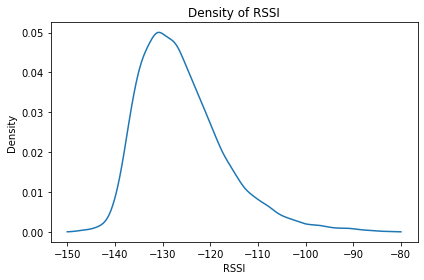

In [31]:

plt.clf() 
plt.figure(figsize=(6, 4))
kernel = gaussian_kde(data_train_all["rssi"])
ax3 = np.linspace(-150, -80, 1000)
plt.plot(ax3, kernel(ax3))
plt.xlabel("RSSI")
plt.ylabel("Density")
_ = plt.title("Density of RSSI")
plt.tight_layout()
plt.show()

Le RSSI représente la force de réception du signal émis par le device.
Nous pouvons constater que la majorité des bsid a une rssi autour de -130. 
Nous allons vérifier qu'il existe bien une relation entre le RSSI et la distance du devise par rapport à la base station. Pour cela, nous disposons des latitudes et longitudes des devises dans les données Train. 
Si la donnée RSSI est fiable, pour une RSSI, nous devrions avoir la même distance entre le devise et la base station.

### Qualité RSSI

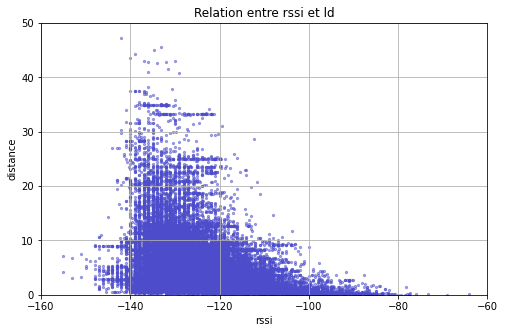

In [32]:
data_train_all = cal_distance(data_train_all)

fig_3 = plt.figure(figsize=(8,5))
plt.scatter(data_train_all['rssi'], data_train_all['distance'], c=[[0.3,0.3,0.8]], alpha=0.5, s=5);
plt.xlim([-160, -60])
plt.xlabel("rssi")
plt.ylim([0, 50])
plt.ylabel("distance")
plt.title('Relation entre rssi et ld')
plt.grid(True)
plt.show()

Cette relation peut être perturbée par:
<li> présence d'obstacles (par exemple les immeubles si la base station est localisée dans un milieu urbain dense)
<li> défaut (manque de précision) éventuel de la base station elle même. 
Concernant ce dernier point, vérifions si les données de lat et lng sont toutes plausibles et/ou ne présentent pas d'anomalie. 

<div class="alert alert-block alert-info"; div align="center">
<span style="font-size:2em";> III - Algorithmes </span></b></div>

Nous avons lu les papiers suivants: 
<br><a href="https://makina-corpus.com/blog/metier/2019/machine-learning-detection-anomalies"> https://makina-corpus.com/blog/metier/2019/machine-learning-detection-anomalies</a>
<br><a href="https://unsupervisedlearning.wordpress.com/2014/08/04/topological-anomaly-detection/"> https://unsupervisedlearning.wordpress.com/2014/08/04/topological-anomaly-detection/</a>
<br><a href="http://telematics.upatras.gr/telematics/system/files/publications/1-s2.0-S1877050920317233-main.pdf"> http://telematics.upatras.gr/telematics/system/files/publications/1-s2.0-S1877050920317233-main.pdf</a>
<br><a href="https://ieeexplore.ieee.org/document/8533826"> Outdoor Fingerprinting Localization Using Sigfox </a>
<br><a href="https://eduscol.education.fr/sti/sites/eduscol.education.fr.sti/files/ressources/pedagogiques/11533/11533-geolocalisation-dans-un-reseau-lorawan-ensps.pdf"> https://eduscol.education.fr/sti/sites/eduscol.education.fr.sti/files/ressources/pedagogiques/11533/11533-geolocalisation-dans-un-reseau-lorawan-ensps.pdf</a>
<br><a href="https://www.researchgate.net/publication/336679965_Comparing_Machine_Learning_Algorithms_for_RSS-Based_Localization_in_LPWAN"> Comparing Machine Learning Algorithms for RSS-Based Localization in LPWAN </a>

Le papier https://www.sciencedirect.com/science/article/abs/pii/S1574119220300687 présente une étude des approches abordées dans la littérature. Les auteurs proposent deux nouveaux algorithmes. Le modèle qui donne le résultat le plus prometteur est celui décrit dans la section 4.2 : une méthode de metric learning.  Une métrique est apprise par un  Random Forest ou un XGboost et elle est ensuite utilisée par le calcul de la distance dans l’algo de k-NN.

 Si $\mathcal{R}^k$ est l’espace des features, les auteurs définissent une fonction $\phi:\mathcal{R}^k\times \mathcal{R}^k\rightarrow \mathbb{R}^k\times \mathbb{R}^k$ comme suit : 
$$\phi(r_1, r_2) :=\left(r_1-r_2, \frac{1}{2}(r_1+r_2)\right).$$ 
L’algorithme

1. calcule la matrice $\phi_{ij}=(\phi(r_i, r_j))_{i,j}$, où $(r_i, r_j)$ est un couple de lignes de la matrice des features 
2. fit et predict le Random Forest pour prédire toutes les distances entre les différents couples des devices
3. utilise la métrique apprise pour le calcul des distances dans l’algorithme k-NN.

    
On a implémenté la première partie de l’algo (disponible içi: <a href="https://drive.google.com/file/d/16e-QE_62M6areOOvXB81zW-I1O_tRUl6/view"> Projet_metric_learning.ipynb </a>) qui a un complexité computationnel $\mathcal{O}(n^2k)$, si $n$ est le numéro des lignes de la matrice des features. Le temps de calcul nécessaire à exécuter notre implémentation de cette partie était trop longue, nous avons abandonné l’idée. 


Suivant tous les papiers que nous avons lu, les algorithmes les plus performants seraient: 
    <li> RandomForestRegressor
    <li> KNeighborsRegressor
<br>Mais nous avons aussi testé d'autres algorithmes, tels que: 
    <li> LinearRegression
    <li> GaussianNB
    <li> CatBoostRegressor

## Début du code

### Liste des bases stations

In [52]:
'''
listOfBs = np.union1d(np.unique(mess_train['bsid']), np.unique(mess_test['bsid'])) 
print (f'Toutes les Base station ID des données train + test: {len(listOfBs)}')
'''
listOfBs = np.union1d(np.unique(mess_test['bsid']), np.unique(mess_train['bsid'])) 
print (f'Toutes les Base station ID des données train + test: {len(listOfBs)}')

Toutes les Base station ID des données train + test: 254


In [53]:
mess_train = data_train_all.iloc[:, : ]
pos_train = data_train_all[['lat', 'lng']]

### Feature Matrix construction

Pour notre modèle, nous utilisons construisons 3 matrices, chaque ligne est un messid, chaque colonne représente une bsid, avec en données: 
<li> les données RSSI:feat_mat_const_rssi, 
<li> les données bs_lat: feat_mat_const_lat,
<li> les données bs_lng: feat_mat_const_lng,
<br>Pour la feat_mat_const_rssi, nous donnons la valeur -155, soit le minimum de toutes les RSSI, lorsque le messid n'a pas la bsid. 
<br>En revanche, pour les matrices feat_mat_const_lat et feat_mat_const_lng, nous affectons la valeur 0 pour les bsid non présente.
<br>
<br>Pour prédire la latitude, nous joignons la matrice RSSI avec la matrice bs_lat: df_feat_rssi_lat.
<br>Pour prédire la longiture,  nous joignons la matrice RSSI avec la matrice bs_lng: df_feat_rssi_lng.

In [54]:
def feat_mat_const_rssi(mess_train, listOfBs):
    '''
        df_feat : ligne= messid unique
                  colonne = bsid
        id_list : liste des messid unique
        
        présence bsid pour le messid = valeur RSSI
        absence  bsid pour le messid = -220
    '''
    df_mess_bs_group = mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = elmt.rssi.values
        id_list[idx] = key
        idx = idx + 1
        
    df_feat = df_feat.replace(0.0, min(mess_train['rssi']))
    
    return df_feat, id_list # add id value of each message for the correspondance to message

In [55]:
def feat_mat_const_lat(mess_train, listOfBs):

    df_mess_bs_group = mess_train.groupby(['messid'], as_index=False) 
    nb_mess = len(np.unique(mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) 
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = elmt.bs_lat.values
        id_list[idx] = key
        idx = idx + 1
        
    #on change les noms de colonnes pour pouvoir faire la jointure
    list_lat =[str(s) + '_lat' for s in listOfBs]   
    df_feat.columns = list_lat 
    
    return df_feat, id_list # add id value of each message for the correspondance to message

In [56]:
def feat_mat_const_lng(mess_train, listOfBs):

    df_mess_bs_group = mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess
    
    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = elmt.bs_lng.values     
        id_list[idx] = key
        idx = idx + 1
        
    #on change les noms de colonnes pour pouvoir faire la jointure
    list_lng =[str(s) + '_lng' for s in listOfBs]   
    df_feat.columns = list_lng
    
    return df_feat, id_list # add id value of each message for the correspondance to message

In [57]:
# Jointure de toutes les features matrix
df_feat_rssi, id_list_rssi = feat_mat_const_rssi(data_train_all, listOfBs)
df_feat_lat, id_list_lat = feat_mat_const_lat(data_train_all, listOfBs)
df_feat_lng, id_list_lat = feat_mat_const_lng(data_train_all, listOfBs)

df_feat_rssi_lat = df_feat_rssi.join(df_feat_lat)
df_feat_rssi_lng = df_feat_rssi.join(df_feat_lng)

In [58]:
# entête de chaque matrice - RSSI + lat
df_feat_rssi_lat.head(2)

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9899_lat,9936_lat,9949_lat,10134_lat,10148_lat,10151_lat,10162_lat,10999_lat,11007_lat,11951_lat
0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# entête de chaque matrice - RSSI + lng
df_feat_rssi_lng.head(2)

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9899_lng,9936_lng,9949_lng,10134_lng,10148_lng,10151_lng,10162_lng,10999_lng,11007_lng,11951_lng
0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,-155.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ground truth construction

In [60]:
def ground_truth_const(mess_train, pos_train):
    '''
    Vraie coordonnées, lat et lng pour chaque messid unique
    '''
    mess_pos = mess_train.copy()
    mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [61]:
ground_truth_lat, ground_truth_lng = ground_truth_const(mess_train, pos_train)
len(ground_truth_lat)

6068

### Prédiction sur les données Train

#### RandomForestRegressor

In [63]:
model_RF_lat =  RandomForestRegressor(max_features='log2', max_depth = 100 ,n_estimators = 250, n_jobs=-1 ) 
model_RF_lng =  RandomForestRegressor(max_features='log2', max_depth = 100 ,n_estimators = 250, n_jobs=-1 ) 

#### KNeighborsRegressor

In [64]:
model_KN_lat =  KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2, n_jobs=-1 )
model_KN_lng =  KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2, n_jobs=-1 )

<div class="alert alert-block alert-info"; div align="center">
<span style="font-size:2em";> IV - Resultats </span></b></div>

In [65]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]) for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [66]:
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

## A- Cross validation

In [67]:
from sklearn.model_selection import cross_val_predict
y_pred_RF_lat = cross_val_predict(model_RF_lat, df_feat_rssi_lat, ground_truth_lat, cv=10)
y_pred_RF_lng = cross_val_predict(model_RF_lng, df_feat_rssi_lng, ground_truth_lng, cv=10)

y_pred_KN_lat = cross_val_predict(model_KN_lat, df_feat_rssi_lat, ground_truth_lat, cv=10)
y_pred_KN_lng = cross_val_predict(model_KN_lng, df_feat_rssi_lng, ground_truth_lng, cv=10)

### Evaluation des erreurs

In [68]:
err_vec_RF = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_RF_lat, y_pred_RF_lng)

err_vec_KN = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_KN_lat, y_pred_KN_lng)

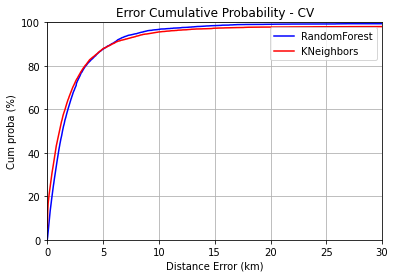

In [69]:
# Graphique de la distribution des erreurs 
values_RF, base_RF = np.histogram(err_vec_RF, bins=50000)
values_KN, base_KN = np.histogram(err_vec_KN, bins=50000)
cumulative_RF = np.cumsum(values_RF) 
cumulative_KN = np.cumsum(values_KN) 

plt.figure();
plt.plot(base_RF[:-1], cumulative_RF / np.float(np.sum(values_RF))  * 100.0, c='blue',  label ='RandomForest')
plt.plot(base_KN[:-1], cumulative_KN / np.float(np.sum(values_KN))  * 100.0, c='red',  label ='KNeighbors')

plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability - CV'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.legend();

In [71]:
# Erreur en kilomètre
print(' RandomForest', np.percentile(err_vec_RF, 80),'\n', 
      'KNeighbors',   np.percentile(err_vec_KN, 80))

 RandomForest 3.4454724000000017 
 KNeighbors 3.390962600000001


## B - Leave 1 device out  strategy 

Nous utilisons les mêmes matrices de feat_mat mais en ajoutant une colonne supplémentaire ['did'] qui représente le devise id de chaque messid. 
Ceci, nous permet d'appliquer la cross-validation utilisation la technique du "leave one devise out".

In [72]:
# Feature Matrix avec les did pour le "leave one out "(LOO)

def feat_mat_rssi_loo(mess_train, listOfBs):
    df_mess_bs_group = mess_train.groupby(['messid'], as_index=False) 
    nb_mess = len(np.unique(mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) 
    idx = 0
    id_list = [0] * nb_mess
    df_feat = df_feat.replace(0.0, min(mess_train['rssi']))
        
    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = elmt.rssi.values
        id_list[idx] = key
        idx = idx + 1

    list_of_did =[]
    for i in id_list:
        list_of_did.append(np.unique(mess_train.loc[mess_train['messid']==i]['did'])[0])

    df_feat['did']=list_of_did
    return df_feat, id_list

def feat_mat_const_lat_loo(mess_train, listOfBs):    
    df_mess_bs_group = mess_train.groupby(['messid' ], as_index=False)
    nb_mess = len(np.unique(mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = elmt.bs_lat.values
        id_list[idx] = key
        idx = idx + 1
        
    list_lat =[str(s) + '_bs_lat' for s in listOfBs]   
    df_feat.columns = list_lat
    return df_feat, id_list 

def feat_mat_const_lng_loo(mess_train, listOfBs):
    df_mess_bs_group = mess_train.groupby(['messid'], as_index=False) 
    nb_mess = len(np.unique(mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) 
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = elmt.bs_lng.values
        id_list[idx] = key
        idx = idx + 1
    list_lng =[str(s) + '_bs_lng' for s in listOfBs]   
    df_feat.columns = list_lng
    return df_feat, id_list 

In [73]:
# Jointure de toutes les features matrix avec did - LOO
df_feat_rssi_loo, id_list_loo  = feat_mat_rssi_loo(data_train_all, listOfBs)
df_feat_lat_loo, id_list_loo  = feat_mat_const_lat_loo(data_train_all, listOfBs)
df_feat_lng_loo, id_list_loo = feat_mat_const_lng_loo(data_train_all, listOfBs)

df_feat_rssi_lat_loo = df_feat_rssi_loo.join(df_feat_lat_loo)
df_feat_rssi_lng_loo = df_feat_rssi_loo.join(df_feat_lng_loo)

In [74]:
model_RF_lat =  RandomForestRegressor(max_features='log2', max_depth = 100 ,n_estimators = 250, n_jobs=-1 ) 
model_RF_lng =  RandomForestRegressor(max_features='log2', max_depth = 100 ,n_estimators = 250, n_jobs=-1 ) 

In [75]:
model_KN_lat =  KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2, n_jobs=-1 )
model_KN_lng =  KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2, n_jobs=-1 )

In [76]:
from sklearn.model_selection import LeaveOneGroupOut

groups = df_feat_rssi_loo['did']
loo = LeaveOneGroupOut()

cv_loo_lat = loo.split(df_feat_rssi_lat_loo, ground_truth_lat, groups)
cv_loo_lng = loo.split(df_feat_rssi_lng_loo, ground_truth_lng, groups)

y_pred_lat_RF_loo = cross_val_predict(model_RF_lat, df_feat_rssi_lat_loo, ground_truth_lat, cv=cv_loo_lat)
y_pred_lng_RF_loo = cross_val_predict(model_RF_lng, df_feat_rssi_lng_loo, ground_truth_lng, cv=cv_loo_lng)

In [77]:
from sklearn.model_selection import LeaveOneGroupOut

groups = df_feat_rssi_loo['did']
loo = LeaveOneGroupOut()

cv_loo_lat = loo.split(df_feat_rssi_lat_loo, ground_truth_lat, groups)
cv_loo_lng = loo.split(df_feat_rssi_lng_loo, ground_truth_lng, groups)

y_pred_lat_KN_loo = cross_val_predict(model_KN_lat, df_feat_rssi_lat_loo, ground_truth_lat, cv=cv_loo_lat)
y_pred_lng_KN_loo = cross_val_predict(model_KN_lng, df_feat_rssi_lng_loo, ground_truth_lng, cv=cv_loo_lng)

In [78]:
err_vec_loo_RF = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat_RF_loo, y_pred_lng_RF_loo)

err_vec_loo_KN = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat_KN_loo, y_pred_lng_KN_loo)

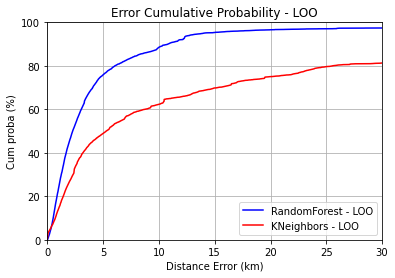

In [79]:
# Graphique de la distribution des erreurs with LOO
values_RF_loo, base_RF_loo = np.histogram(err_vec_loo_RF, bins=50000)
values_KN_loo, base_KN_loo = np.histogram(err_vec_loo_KN, bins=50000)
cumulative_RF_loo = np.cumsum(values_RF_loo) 
cumulative_KN_loo = np.cumsum(values_KN_loo) 

plt.figure();
plt.plot(base_RF_loo[:-1], cumulative_RF_loo / np.float(np.sum(values_RF_loo))  * 100.0, c='blue',  label ='RandomForest - LOO')
plt.plot(base_KN_loo[:-1], cumulative_KN_loo / np.float(np.sum(values_KN_loo))  * 100.0, c='red',  label ='KNeighbors - LOO')

plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability - LOO'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.legend();

In [80]:
# Erreur en kilomètre with LOO
print(' RandomForest with LOO',np.percentile(err_vec_loo_RF, 80), '\n', 
      'KNeighbors with LOO',   np.percentile(err_vec_loo_KN, 80))

 RandomForest with LOO 6.058582000000001 
 KNeighbors with LOO 25.565088199999998


Commentaire:
Nous pouvons voir que les deux façons de faire la validation croisée donnent des résultats très différents. 
Dans le cas du LEAVE ONE DEVICE OUT, à chaque étape, le train est presque le même (nous utilisons comme test les messages produits par un seul device). Cette forte corrélation entre les différents trains fixés à chaque étape augmente la variance de l'estimateur de l'erreur par rapport à la validation croisée avec cv = 10.
Sachant que les résultats sont très proches entre le RF (3.4558608) et la KN (3.3909626), nous retenons le RF. 

Références utilisées: 
<br><a href="http://www.russpoldrack.org/2012/12/the-perils-of-leave-one-out.html"> The perils of leave-one-out crossvalidation for individual difference analyses </a>

T. Hastie, R. Tibshirani and J. Friedman, “The Elements of Statistical Learning Data Mining, Inference, and Prediction,” New York Springer-Verlag, 2001
chapitre 7

## C- Construction des prédictions sur le jeu de donnée Test

In [81]:
model_RF_lat =  RandomForestRegressor(max_features='log2', max_depth = 100 ,n_estimators = 250, n_jobs=-1 ) 
model_RF_lng =  RandomForestRegressor(max_features='log2', max_depth = 100 ,n_estimators = 250, n_jobs=-1 ) 

model_RF_lat.fit(df_feat_rssi_lat, ground_truth_lat)
model_RF_lng.fit(df_feat_rssi_lng, ground_truth_lng)

y_pred_RF_lat = model_RF_lat.predict(df_feat_rssi_lat)
y_pred_RF_lng = model_RF_lng.predict(df_feat_rssi_lng)

### Construction des prédictions sur les données test

In [94]:
listOfBs = np.union1d(np.unique(mess_test['bsid']), np.unique(mess_train['bsid'])) 
print (f'Toutes les Base station ID des données train + test: {len(listOfBs)}')

Toutes les Base station ID des données train + test: 254


In [95]:
df_feat_test_rssi, id_list_test_rssi = feat_mat_const_rssi(mess_test, listOfBs)
df_feat_test_lat, id_list_test_lat = feat_mat_const_lat(mess_test, listOfBs)
df_feat_test_lng, id_list_test_lat = feat_mat_const_lng(mess_test, listOfBs)

df_feat_test_rssi_lat = df_feat_test_rssi.join(df_feat_test_lat)
df_feat_test_rssi_lng = df_feat_test_rssi.join(df_feat_test_lng)

In [96]:
y_pred_lat_test_RF = model_RF_lat.predict(df_feat_test_rssi_lat)
y_pred_lng_test_RF = model_RF_lng.predict(df_feat_test_rssi_lng)

### Prediction sur le jeu de données Test¶

In [97]:
test_res_RF = pd.DataFrame(np.array([y_pred_lat_test_RF, y_pred_lng_test_RF]).T, columns = ['lat', 'lng'])
test_res_RF['messid'] = id_list_test_rssi
test_res_RF.to_csv('pred_pos_test_list_RF.csv', index=False)

In [98]:
test_res_RF.head(2)

,lat,lng,messid
0,39.731056,-105.052709,573be2503e952e191262c351
1,39.778292,-105.068983,573c05f83e952e1912758013
